# CIFAR10-embeddings dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval.random import RandomEvaluator
from opendataval.dataval.margcontrib import LeaveOneOut, DataShapley, BetaShapley
from opendataval.dataval.influence import InfluenceFunctionEval
from opendataval.dataval.dvrl import DVRL
from opendataval.dataval.knnshap import KNNShapley
from opendataval.dataval.margcontrib.banzhaf import DataBanzhaf
from opendataval.dataval.ame import AME
from opendataval.dataval.oob import DataOob

from opendataval.experiment import ExperimentMediator

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: CIFAR10-embeddings
- Model: Pretrained ResNet50 + LogisticRegression
- Metric: Classification accuracy

In [2]:
dataset_name = "cifar10-embeddings"
train_count, valid_count, test_count = 500, 100, 300
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "LogisticRegression" # will train a logistic regression model built with PyTorch (sklearn's logistic regression can be very slow).
metric_name = "accuracy"
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
device = torch.device("cuda")

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.5666666626930237


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley ## slow
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley ## slow
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000) # Data-OOB
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000546


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.58it/s]


Elapsed time LeaveOneOut(): 0:00:10.534947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.14it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:16.096210


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.54it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:18.749291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 10599.35it/s]


Elapsed time KNNShapley(k_neighbors=100): 0:00:00.091470


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.87it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:14.533490


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.51it/s]


Elapsed time AME(num_models=1000): 0:00:46.619425


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.81it/s]

Elapsed time DataOob(num_models=1000): 0:00:22.844602
CPU times: user 2min 2s, sys: 282 ms, total: 2min 2s
Wall time: 2min 9s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/cifar10-embeddings_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.187266
DVRL(rl_epochs=2000),0.291667
DataBanzhaf(num_models=1000),0.199357
DataOob(num_models=1000),0.333333
InfluenceFunctionEval(num_models=1000),0.207120
KNNShapley(k_neighbors=100),0.209974
LeaveOneOut(),0.186551
RandomEvaluator(),0.173333


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

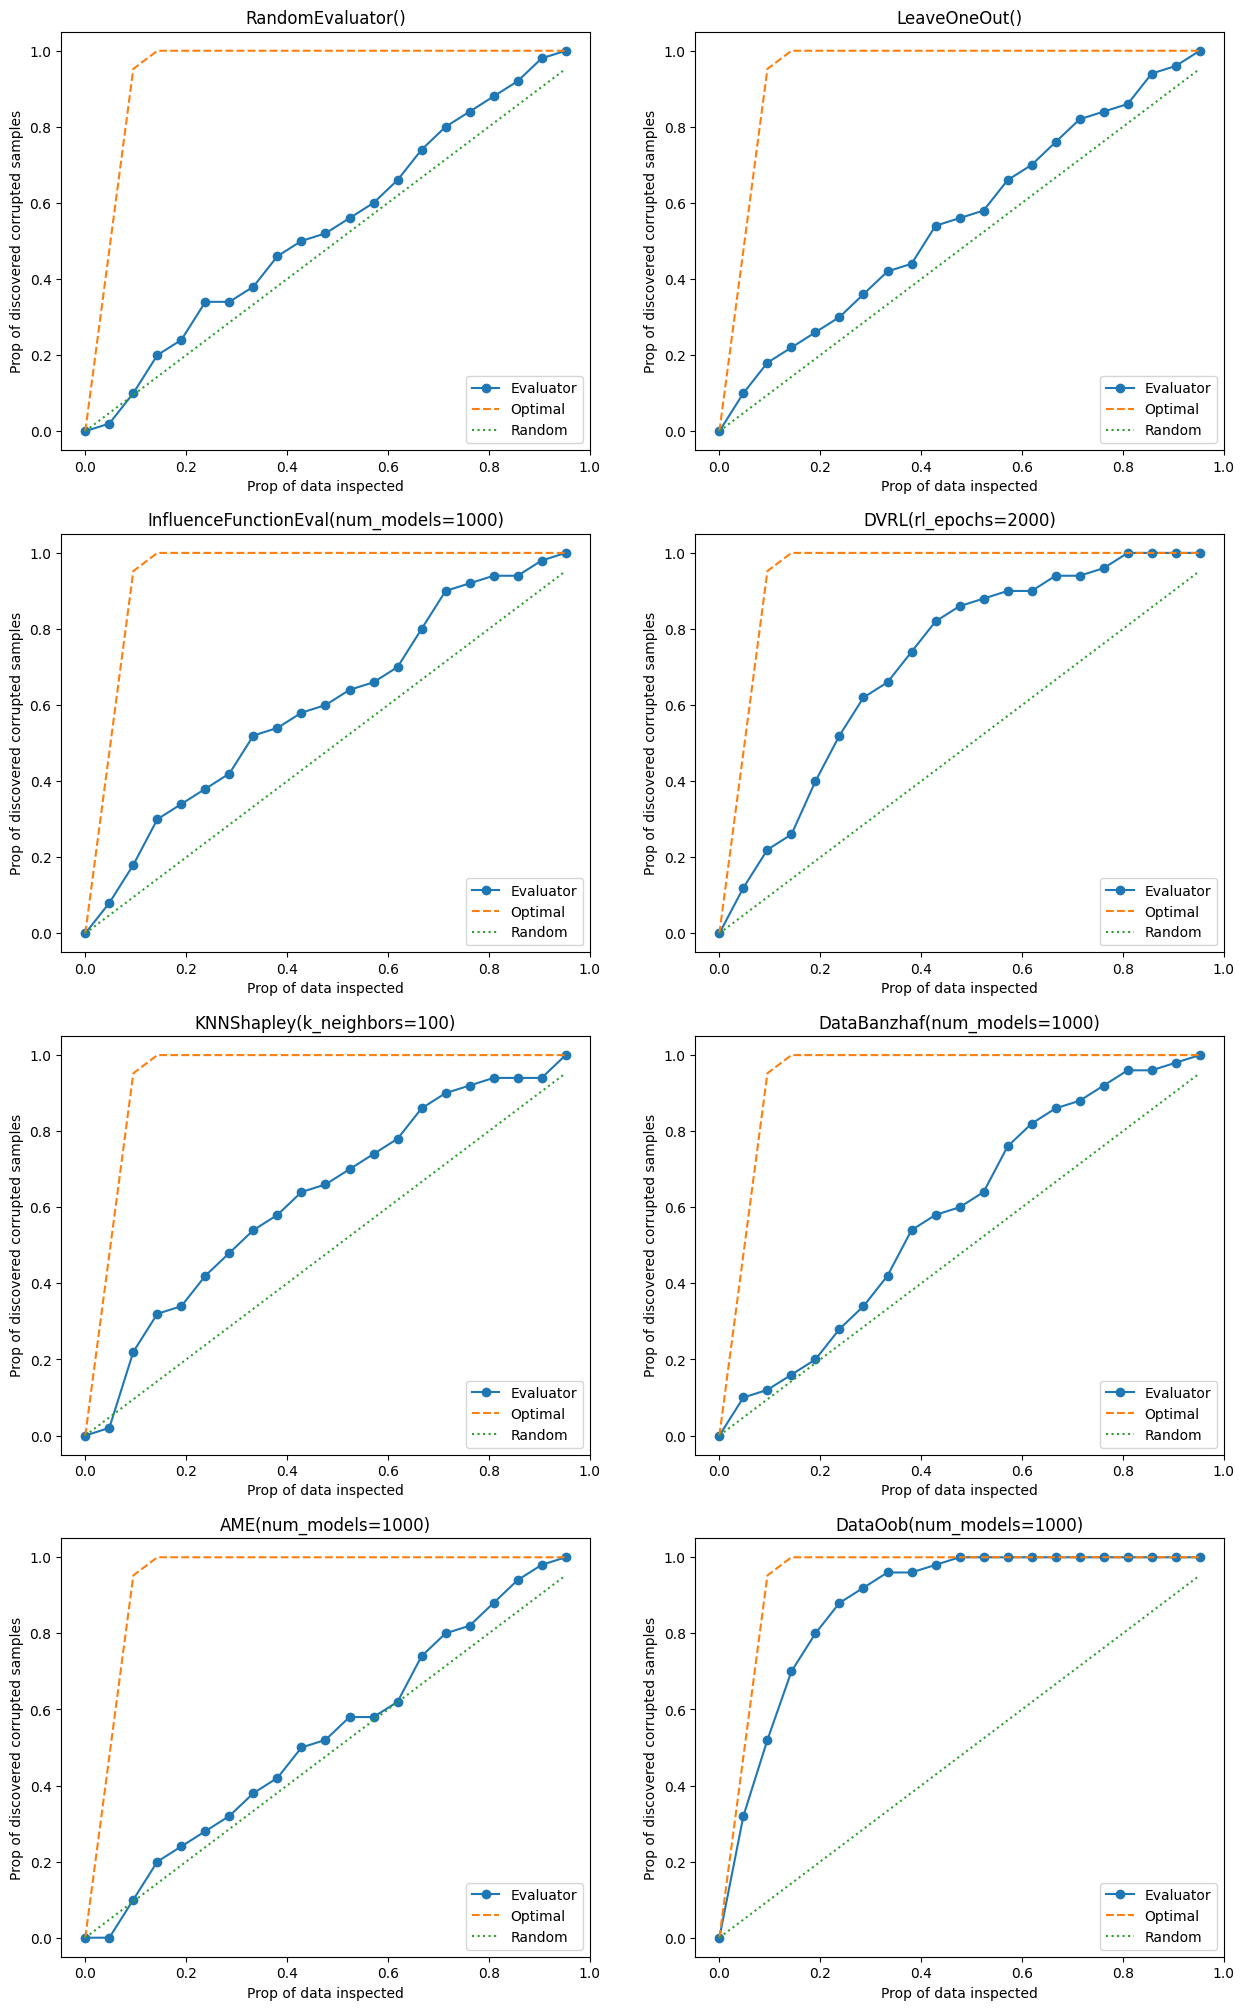

In [7]:
fig = plt.figure(figsize=(15, 25))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

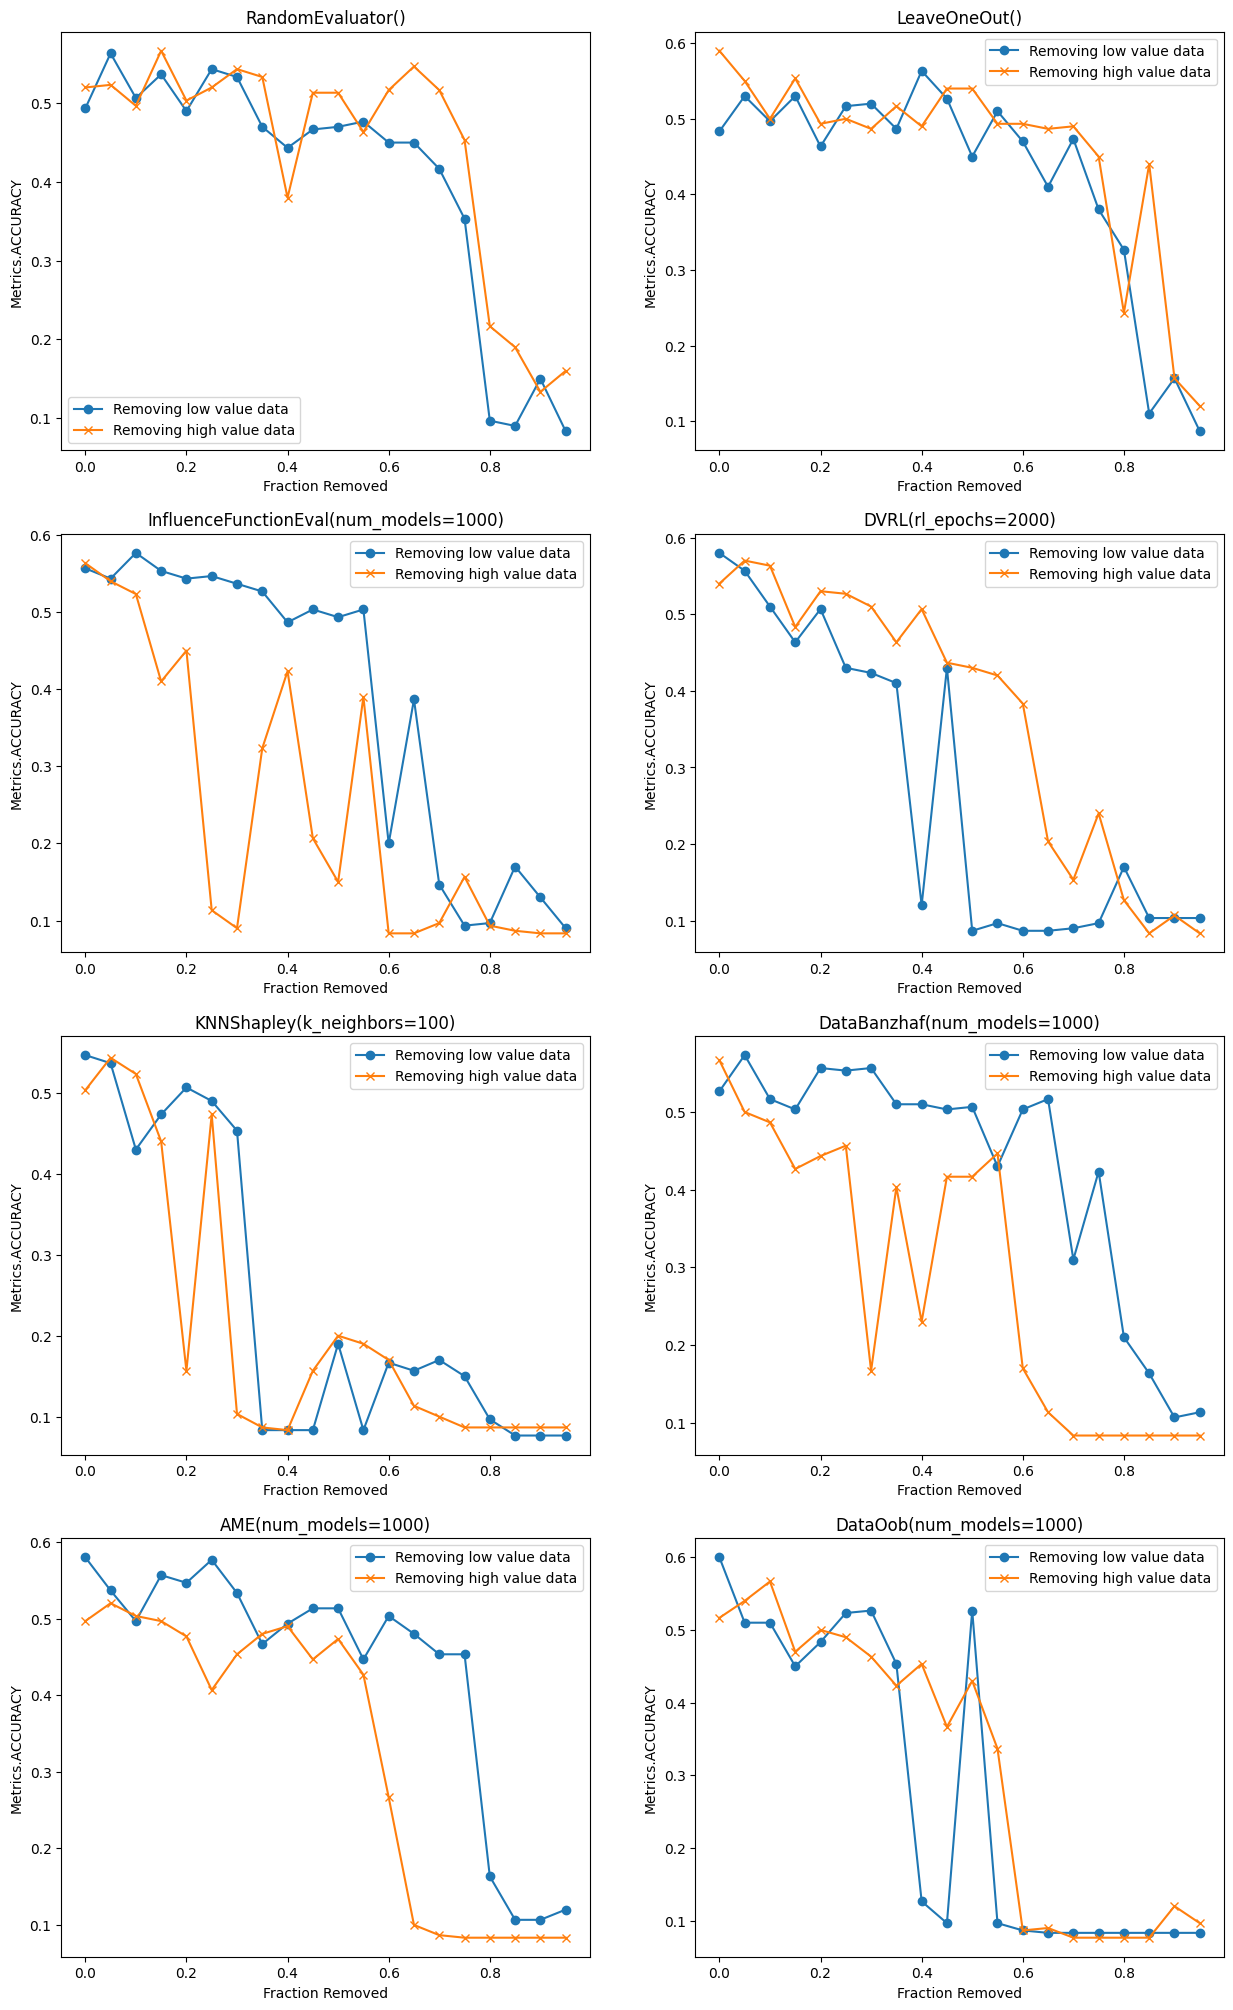

In [8]:
fig = plt.figure(figsize=(15, 25))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.493333,0.52,0.0
RandomEvaluator(),0.563333,0.523333,0.05
RandomEvaluator(),0.506667,0.496667,0.1
RandomEvaluator(),0.536667,0.566667,0.15
RandomEvaluator(),0.49,0.503333,0.2
...,...,...,...
DataOob(num_models=1000),0.083333,0.076667,0.75
DataOob(num_models=1000),0.083333,0.076667,0.8
DataOob(num_models=1000),0.083333,0.076667,0.85
DataOob(num_models=1000),0.083333,0.12,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),14291,0.350674
RandomEvaluator(),14667,0.537847
RandomEvaluator(),30983,0.228212
RandomEvaluator(),14862,0.220464
RandomEvaluator(),43511,0.025539
...,...,...
DataOob(num_models=1000),27968,0.854881
DataOob(num_models=1000),1472,0.002801
DataOob(num_models=1000),16933,0.0
DataOob(num_models=1000),38201,0.134211
